<a href="https://colab.research.google.com/github/GarzonDiegoINL/Characterization/blob/main/Parser_for_STAR_logs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import glob as gl
import numpy as np
import matplotlib.pyplot as plt

# Parsing the data

In [2]:
def predict_encoding(file, n_lines: int=20) -> str:
    '''Predict a file's encoding using chardet'''
    import chardet

    # Open the file as binary data
    with open(log_file, 'rb') as f:
        # Join binary lines for specified number of lines
        rawdata = b''.join([f.readline() for _ in range(n_lines)])

    return chardet.detect(rawdata)['encoding']

def open_csv(filename):
  import csv
  with open(filename, newline='') as f:
      reader = csv.reader(f)
      try:
          for row in reader:
              print(row)
      except csv.Error as e:
          print('file {}, line {}: {}'.format(filename, reader.line_num, e))

def replace_txt(log_file, changes = {'OFF': 'OFF, OFF, OFF, OFF, OFF',
                                     "_.*?,\s*_":'_  _',
                                     '\0': '',
                                     '_,      _': '_  _'}):
  import csv
  import re

  encoding_file = predict_encoding(log_file)
  #print(encoding_file)

  new_rows = [] # a holder for our modified rows when we make them

  with open(log_file, 'r', encoding=encoding_file, errors='ignore') as f:
    file_txt = f.read()
    re_date = re.search(r'\d{4}/\d{2}/\d{2} \d{2}:\d{2}:\d{2}\.\d{3}', file_txt)
    file_txt = file_txt[re_date.start():]
    for key, value in changes.items(): # iterate over 'changes' dictionary
      file_txt = re.sub(key, value, file_txt) # make the substitutions

          #As a guide when this error appears: "Error: field larger than field limit (131072)" Check your raw file, because maybe you have a set of dates without any data in your file

  log_file_processed = 'processed_' + log_file

  with open(log_file_processed, 'w') as f:
      # Overwrite the old file with the modified rows
      f.write(file_txt)
      f.close()


  return log_file_processed

def find_columns(log_file):
  #AI means Analog Input
  columns = ['Info', 'AI-2', 'AI-3', 'AI-4',
             'Shutter-1', 'Shutter-2', 'Shutter-3', 'Shutter-4']

  #with open(log_file, "r", errors='ignore') as f:
   # line_txt = f.read().replace('_                _        _             _', ',').replace('OFF', 'OFF, OFF, OFF, OFF, OFF')

  #with open(log_file, "w") as f:
  #  f.write(line_txt)

  with open(log_file, "r", errors='ignore') as f:
    raw_data = f.readlines()

  headers = raw_data[1]

  if 'RF' in headers:
    columns.extend(['RF-Power', 'RF-R. Power', 'RF-Ct', 'Rf-Cl', 'RF-Voltage'])
  if '520A211-0002' in headers:
    columns.extend(['Cu Rich-Mo - real V', 'Cu Rich-Mo - real A', 'Cu Rich-Mo - set V', 'Cu Rich-Mo - set A'])
  if '524A134-0007' in headers:
    columns.extend(['CIG - real V', 'CIG - real A', 'CIG - set V', 'CIG - set A'])
  if '520A211-0006' in headers:
    columns.extend(['Mo - real V', 'Mo - real A', 'Mo - set V', 'Mo - set A'])

  columns.extend(['motor1-Act', 'motor1-Dst', 'motor2-Act', 'motor2-Dst'])

  columns.extend(['Ar - set flow', 'Ar - real flow', 'Ar - 1', 'Ar - 2'])

  columns.extend(['O - set flow', 'O - real flow', 'O - 1', 'O - 2'])

  columns.extend(['EuroTherm - Win - real T', 'EuroTherm - Win - set T', 'EuroTherm - Win - 1', 'EuroTherm - Win - 2'])

  columns.extend(['EuroTherm - CIG - real T', 'EuroTherm - CIG - set T', 'EuroTherm - CIG - 1', 'EuroTherm - CIG - 2'])

  return columns

def get_data(log_file):

  log_file_processed = replace_txt(log_file)

  columns = find_columns(log_file)

  df = pd.read_csv(log_file_processed, delimiter = ',', skiprows=1, quoting=3, skip_blank_lines=True,
                   header=None, encoding_errors='replace')# #on_bad_lines='skip', )

  df_raw = df.copy()

  #treat time column 1st column
  df[0] = df[0].str.replace('_', ',', 1).str.replace('_ ', '').str.replace(" _", "")

  df.rename(columns={x:y for x,y in zip(df_raw.columns, columns)}, inplace=True)

  #Drop last row and column
  df.drop(df[df['Info'] == 'CLOSING'].index, inplace=True)
  df.drop(columns=df.columns[-1], inplace=True)

  #get the information from the info column (first column in the file)
  df['Time'] = df['Info'].str.extract(r'(\d{4}/\d{2}/\d{2} \d{2}:\d{2}:\d{2}\.\d{3})')
  df['Time'] = pd.to_datetime(df['Time'])

  look_for_recipe = df['Info'].str.split('STEP \d{3}', expand=True, regex=True)

  if look_for_recipe.shape[-1] > 1:
    df['Info Recipe'] = df['Info'].str.extract(r'(,.*STEP \d{3})')
    df['Info Recipe'] = df['Info Recipe'].str.replace(',', '')
    df['AI-1'] = df['Info'].str.extract(r'(\d\.\d{5})')
    recipe_step = df['Info Recipe'].str.split('STEP', expand=True)
    df['Recipe'] = recipe_step[0]
    df['Step'] = pd.to_numeric(recipe_step[1])
  else:
    df['AI-1'] = df['Info'].str.replace(r'\d{4}/\d{2}/\d{2} \d{2}:\d{2}:\d{2}\.\d{3}', '', regex=True).str.replace(',', '')
    df['AI-1'] = pd.to_numeric(df['AI-1'])


  if 'RF-Power' in columns:
    df = treat_data_RF(df)
  elif 'Cu Rich-Mo - real V' in columns or 'CIG - real V' in columns or 'Mo - real V' in columns:
    df = treat_data_DC(df)

  return df, df_raw

def treat_data_RF(df):

  #drop all rows when the targets are OFF
  df.drop(index=df[df['RF-Power'].str.contains('OFF')].index, inplace=True)

  #modify strings for the different columns to get only the numerical data
  columns_to_numeric = ['RF-Power', 'RF-R. Power', 'RF-Ct', 'Rf-Cl', 'RF-Voltage',
                        'motor1-Act', 'motor1-Dst', 'motor2-Act', 'motor2-Dst',
                        'Ar - set flow', 'Ar - real flow', 'O - set flow', 'O - real flow']
  values_to_replace = ['', '', 'CT:', 'CL:', 'B:',
                      'Act: ', 'Dst: ', 'Act: ', 'Dst: ',
                      '1:', '1:', 'B:', 'B:']

  for col, val in zip(columns_to_numeric, values_to_replace):
    if 'RF-Voltage' in col:
      df[col] = df[col].str.replace('V', '')
    df[col] = pd.to_numeric(df[col].str.replace(val, ''))

  return df

def treat_data_DC(df):

  cols = df.columns

  columns_voltage = [x for x in cols if ' V' in x]
  columns_current = [x for x in cols if ' A' in x]

  columns_to_numeric = columns_voltage + columns_current + ['motor1-Act', 'motor1-Dst', 'motor2-Act', 'motor2-Dst',
                                                            'Ar - set flow', 'Ar - real flow', 'O - set flow', 'O - real flow']

  values_to_replace = ['V'] * len(columns_voltage) + ['A'] * len(columns_current) + ['Act: ', 'Dst: ', 'Act: ', 'Dst: ',
                                                                                     '1:', '1:', 'B:', 'B:']
  for col, val in zip(columns_to_numeric, values_to_replace):
    df[col] = pd.to_numeric(df[col].str.replace(val, ''))


  return df

# Plotting the data

In [3]:
def plot_power(df, ax, log_file):
  y = df['RF-Power']
  diff_y = y - df['RF-R. Power']
  x = df['Time']

  ax.scatter(x, y,  marker='o', facecolors='none', edgecolors='k', s=20, label='Power')
  ax.scatter(x, diff_y, s=15, marker='v', color='red', label='$\Delta P$')

  #ax.set_title('RF Power')
  ax.set_title('RF deposition - ' + log_file.split('.log')[0], fontsize=15)
  ax.set_xlabel('Time')
  ax.set_ylabel('Power (W)')
  ax.legend()

def plot_voltage(df, ax, power_type, plot_set_voltage=False, plot_Cu_rich=False):
  if power_type == 'RF':
    y = df['RF-Voltage']
    x = df['Time']


    ax.scatter(x, y,  marker='o', c='b', s=20, label='Voltage')

    #ax.set_title('RF Voltage')
    ax.set_xlabel('Time')
    ax.set_ylabel('Voltage (V)')
    ax.legend()
  elif power_type == 'DC':
    columns_set_voltage = [x for x in df.columns if 'set V' in x]
    columns_real_voltage = [x for x in df.columns if 'real V' in x]

    if len(columns_set_voltage) < 2:
      plot_Cu_rich = True

    x = df['Time']
    for col in columns_set_voltage:
      y = df[col]
      if np.mean(y) != 630 and plot_set_voltage:
        if plot_Cu_rich:
            ax.scatter(x, y, s=30, marker='o', facecolors='none', edgecolors='b', label=col)
        else:
          if 'Cu Rich-Mo' not in col:
            ax.scatter(x, y, s=30, marker='o', facecolors='none', edgecolors='b', label=col)
    for col in columns_real_voltage:
      y = df[col]
      if plot_Cu_rich:
        ax.scatter(x, y,  marker='o', c='b', s=10, label=col)
      else:
        if 'Cu Rich-Mo' not in col:
          ax.scatter(x, y,  marker='o', c='b', s=10, label=col)

    ax.set_xlabel('Time')
    ax.set_ylabel('Voltage (V)')
    ax.legend()

def plot_current(df, ax, log_file, plot_Cu_rich=False):
  columns_set_current = [x for x in df.columns if 'set A' in x]
  columns_real_current = [x for x in df.columns if 'real A' in x]

  if len(columns_set_current) < 2:
    plot_Cu_rich = True

  x = df['Time']

  for col in columns_set_current:
    y = df[col]
    if plot_Cu_rich:
      ax.scatter(x, y, s=30, marker='o', facecolors='none', edgecolors='r', label=col)
    else:
      if 'Cu Rich-Mo' not in col:
        ax.scatter(x, y, s=30, marker='o', facecolors='none', edgecolors='r', label=col)

  for col in columns_real_current:
    y = df[col]
    if plot_Cu_rich:
      ax.scatter(x, y,  marker='o', c='r', s=10, label=col)
    else:
      if 'Cu Rich-Mo' not in col:
        ax.scatter(x, y,  marker='o', c='r', s=10, label=col)

  ax.set_title('DC deposition - ' + log_file.split('.log')[0], fontsize=15)
  ax.set_xlabel('Time')
  ax.set_ylabel('Current (A)')
  ax.legend()

def plot_ct_cl(df, ax):
  y_ct = df['RF-Ct']/10
  y_cl = df['Rf-Cl']/10
  x = df['Time']

  ax.scatter(x, y_ct,  marker='o', color='g', s=20, label='CT')
  ax.scatter(x, y_cl, s=20, marker='o', color='gray', label='CL')

  #ax.set_title('RF CT and CL')
  ax.set_xlabel('Time')
  ax.set_ylabel('CT/CL (%)')
  ax.legend()


def plot_gas_flow(df, ax):
  y_Ar = df['Ar - real flow']
  y_Ar_ = df['Ar - set flow']
  y_O = df['O - real flow']
  y_O_ = df['O - set flow']
  x = df['Time']

  ax.scatter(x, y_Ar,  marker='o', color='r', s=10, label='Ar flow')
  ax.scatter(x, y_Ar_, s=30, marker='o', facecolors='none', edgecolors='r', label='Set Ar flow')

  ax.scatter(x, y_O,  marker='o', color='b', s=10, label='O$_2$ flow')
  ax.scatter(x, y_O_, s=30, marker='o', facecolors='none', edgecolors='b', label='Set O$_2$ flow')

  #ax.set_title('Gas Flow')
  ax.set_ylabel('Flow (sccm)')
  ax.set_xlabel('Time')
  ax.legend()

def plot_temperature(df, ax, chamber):
  if chamber.lower() == 'cig':
    y_win = df['EuroTherm - CIG - real T']
    y_win_ = df['EuroTherm - CIG - set T']
  elif chamber.lower() == 'window':
    y_win = df['EuroTherm - Win - real T']
    y_win_ = df['EuroTherm - Win - set T']

  x = df['Time']

  ax.scatter(x, y_win,  marker='o', color='k', s=10, label='Chamber Temperature')
  if np.mean(y_win_) != 0:
    ax.scatter(x, y_win_, s=30, marker='o', facecolors='none', edgecolors='k', label='Set Chamber Temperature')

  #ax.set_title('Chamber Temperature')
  ax.set_ylabel('Temperature (°C)')
  ax.set_xlabel('Time')
  ax.legend()

def plot_RF(df, log_file):

  delta_time_h = (df['Time'].max() - df['Time'].min()).seconds//3600

  x_size = max(10, delta_time_h*3)


  fig, axs = plt.subplots(5, 1, figsize=(x_size, 35))

  plot_power(df, axs[0], log_file)
  plot_voltage(df, axs[1], 'RF')
  plot_ct_cl(df, axs[2])
  plot_gas_flow(df, axs[3])
  plot_temperature(df, axs[4], 'Window')
  fig.tight_layout()
  fig.savefig('RF Sputt. - ' + log_file.split('.log')[0] + '.png')
  plt.show()

def plot_DC(df, log_file):

  delta_time_h = (df['Time'].max() - df['Time'].min()).seconds//3600

  x_size = max(10, delta_time_h*3)
  y_size = 6

  if 'CIG - real V' in df.columns:
    no_graphs = 4
  else:
    no_graphs = 3

  fig, axs = plt.subplots(no_graphs, 1, figsize=(x_size, y_size*no_graphs))

  plot_current(df, axs[0], log_file)
  plot_voltage(df, axs[1], 'DC')
  plot_gas_flow(df, axs[2])
  if 'CIG - real V' in df.columns:
    plot_temperature(df, axs[3], 'CIG')
  fig.tight_layout()
  fig.savefig('DC Sputt. - ' + log_file.split('.log')[0] + '.png')
  plt.show()

# Try with your data here

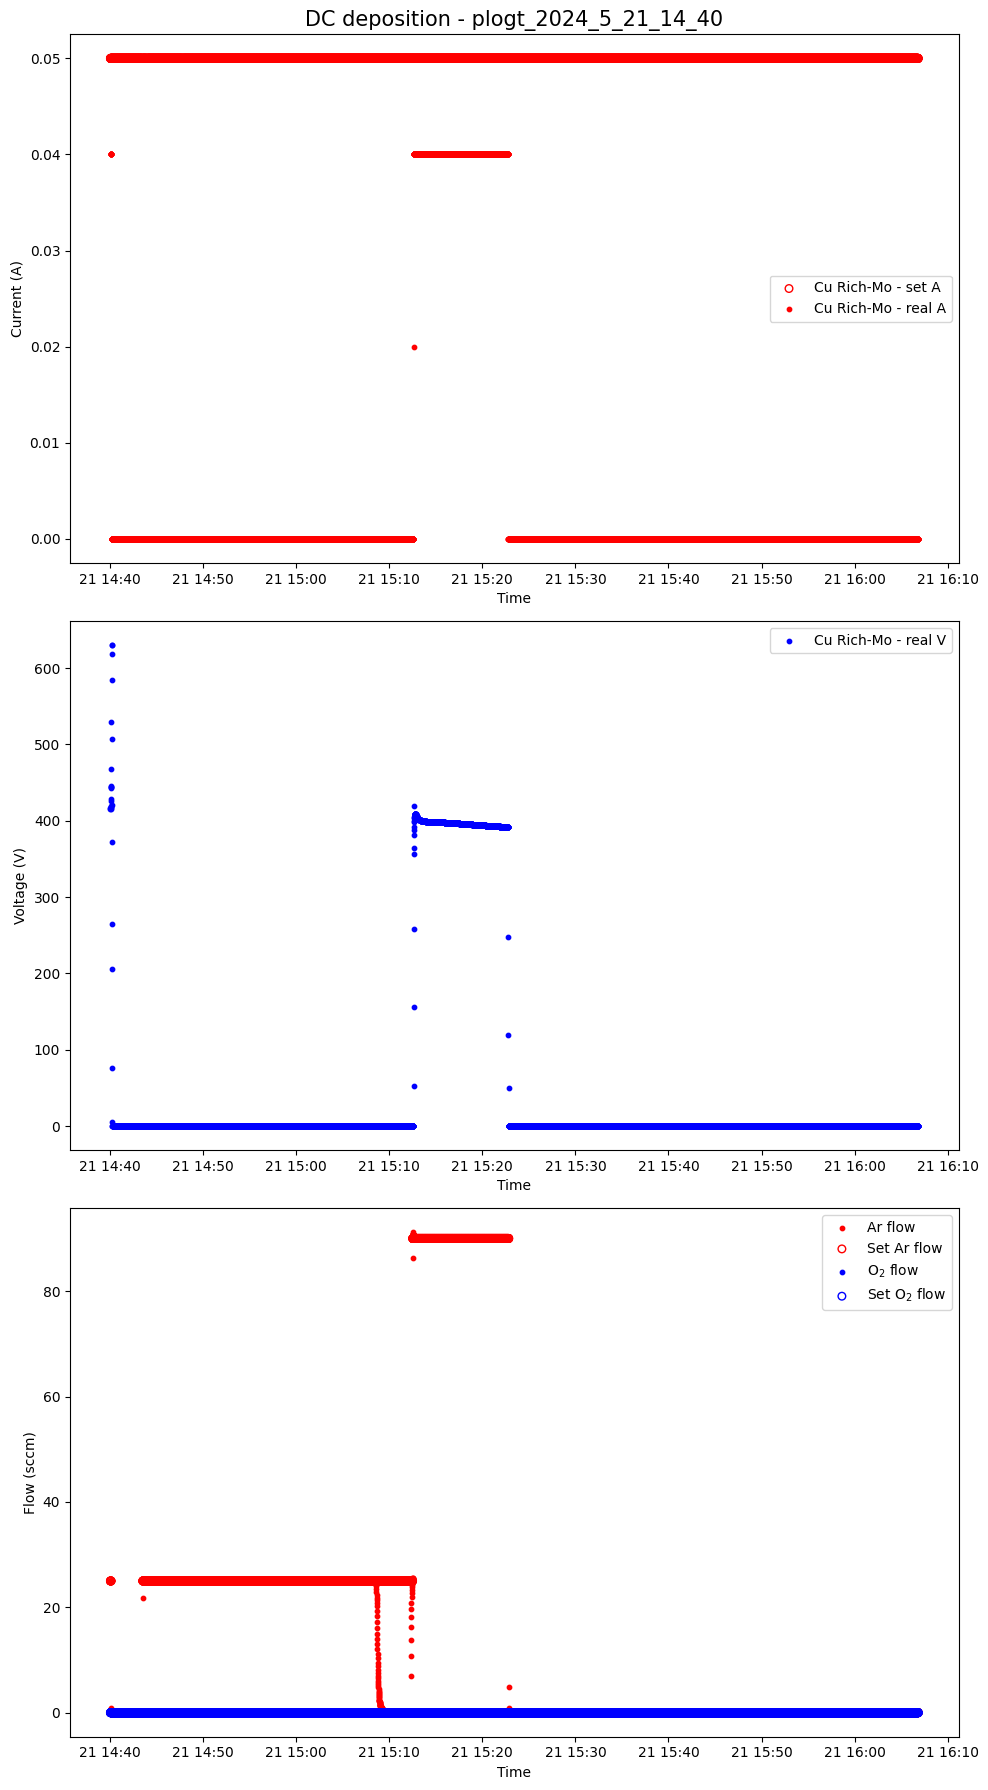

The file plogt_2025_2_20_15_44.log does not have any information to be plotted
The file plogt_2025_2_20_14_0.log does not have any information to be plotted
The file plogt_2025_1_30_11_29.log does not have any information to be plotted
The file plogt_2025_2_20_14_5.log does not have any information to be plotted


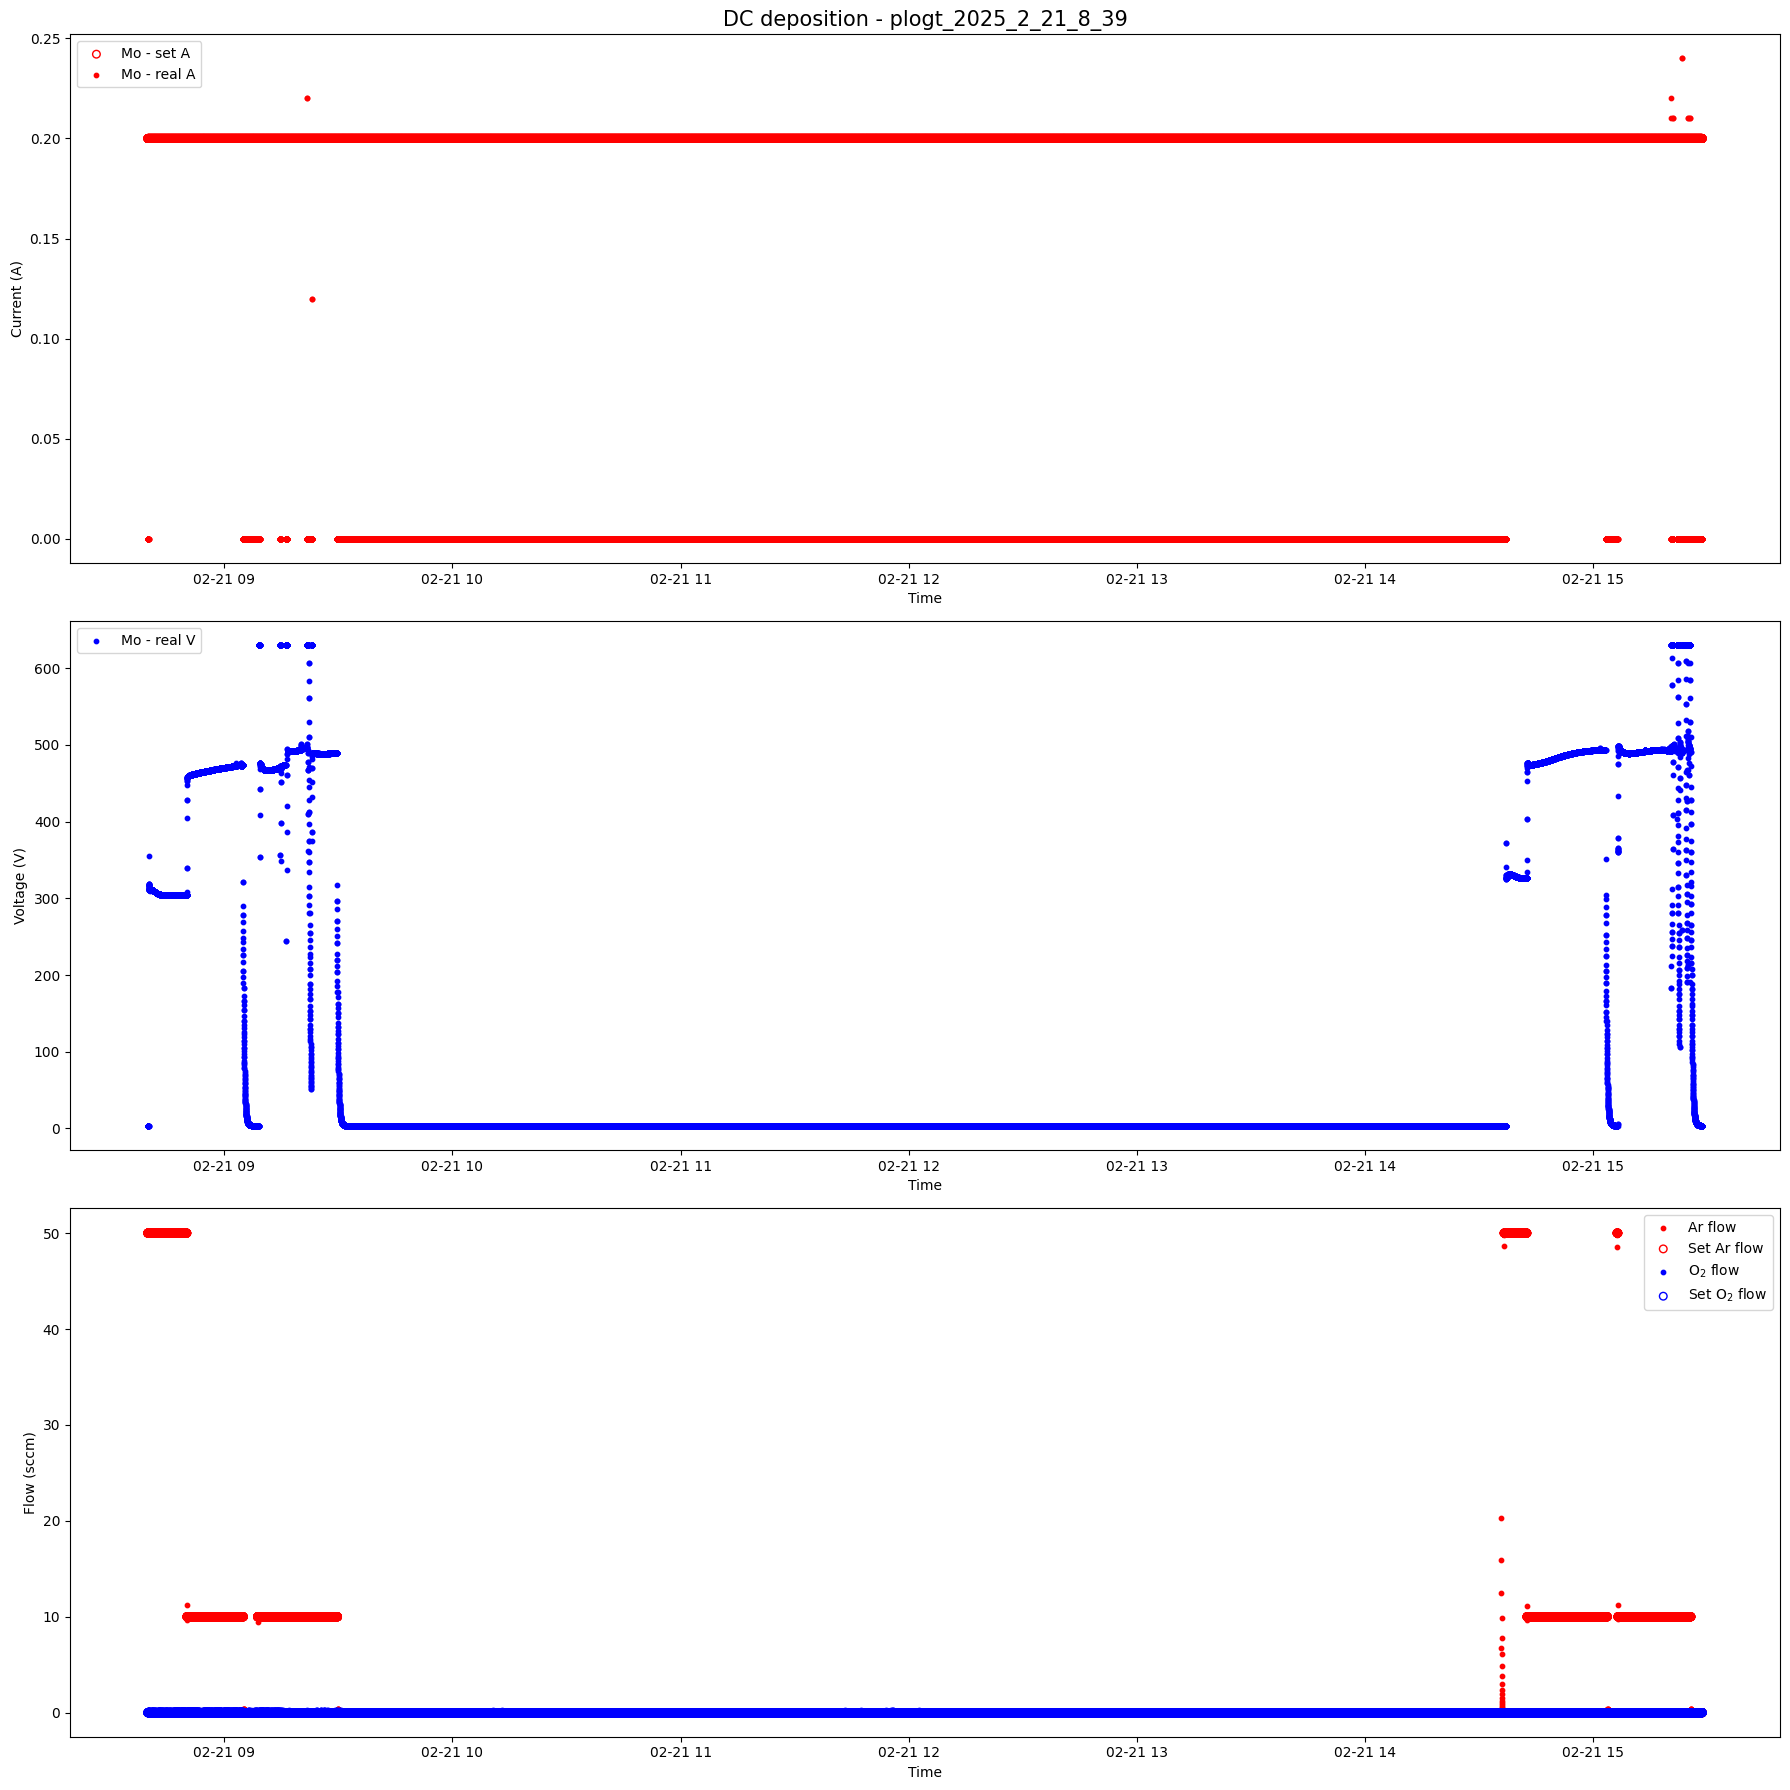

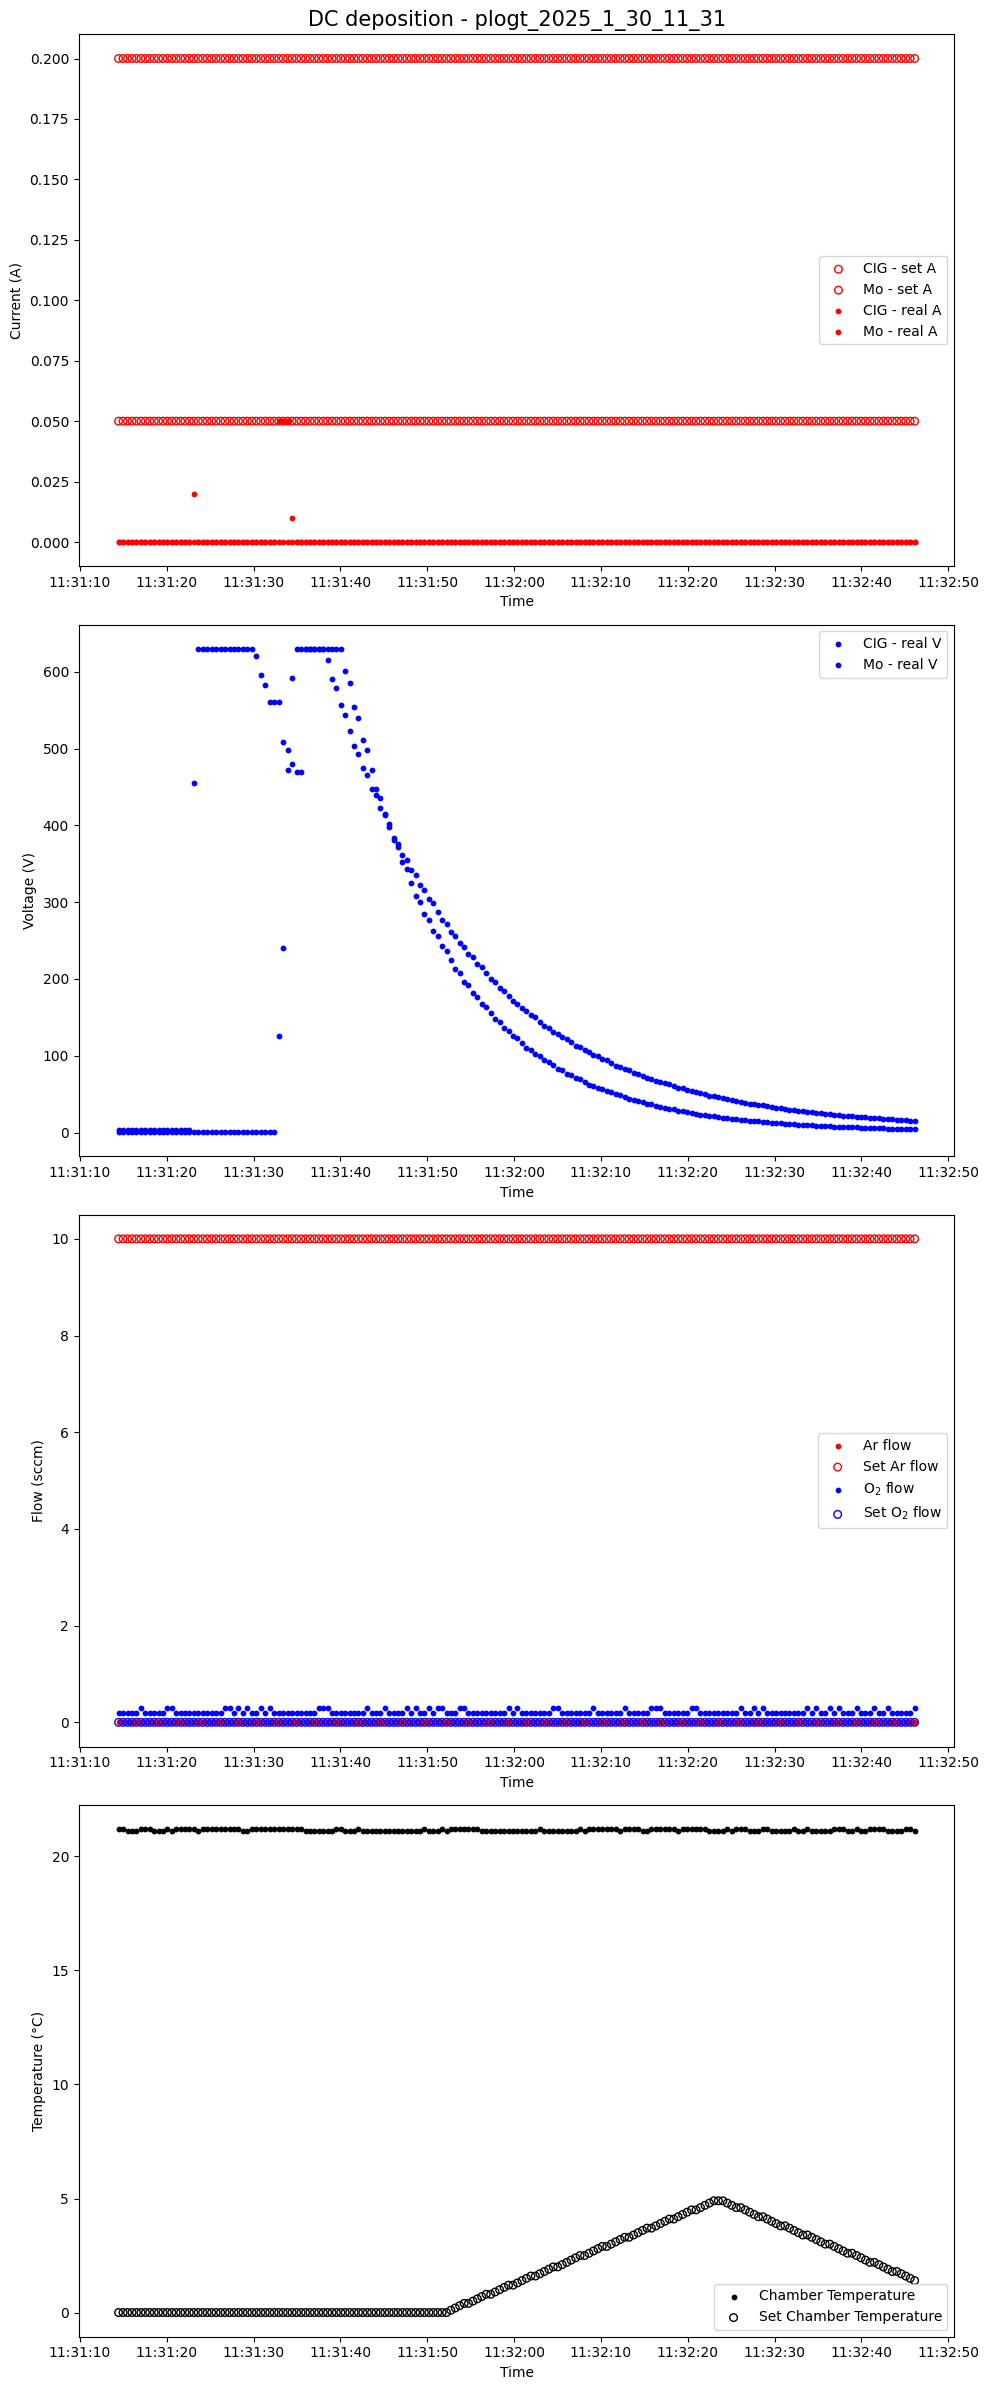

The file plogt_2025_2_20_14_6.log does not have any information to be plotted


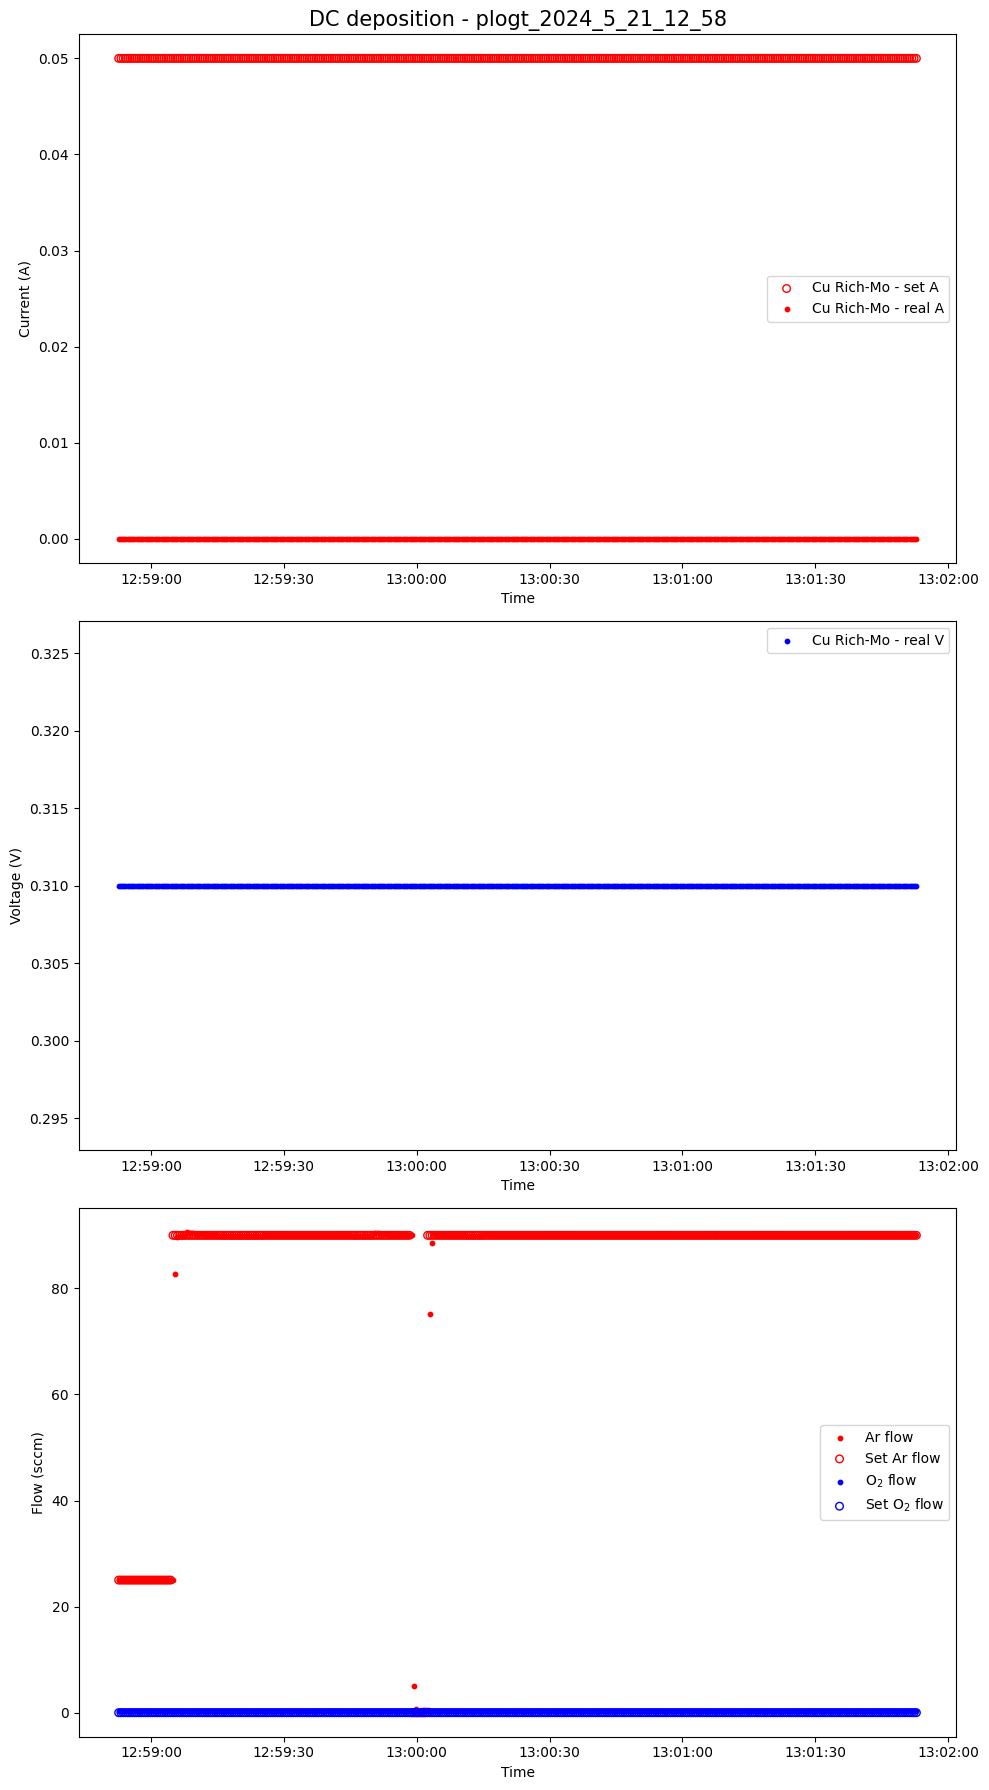

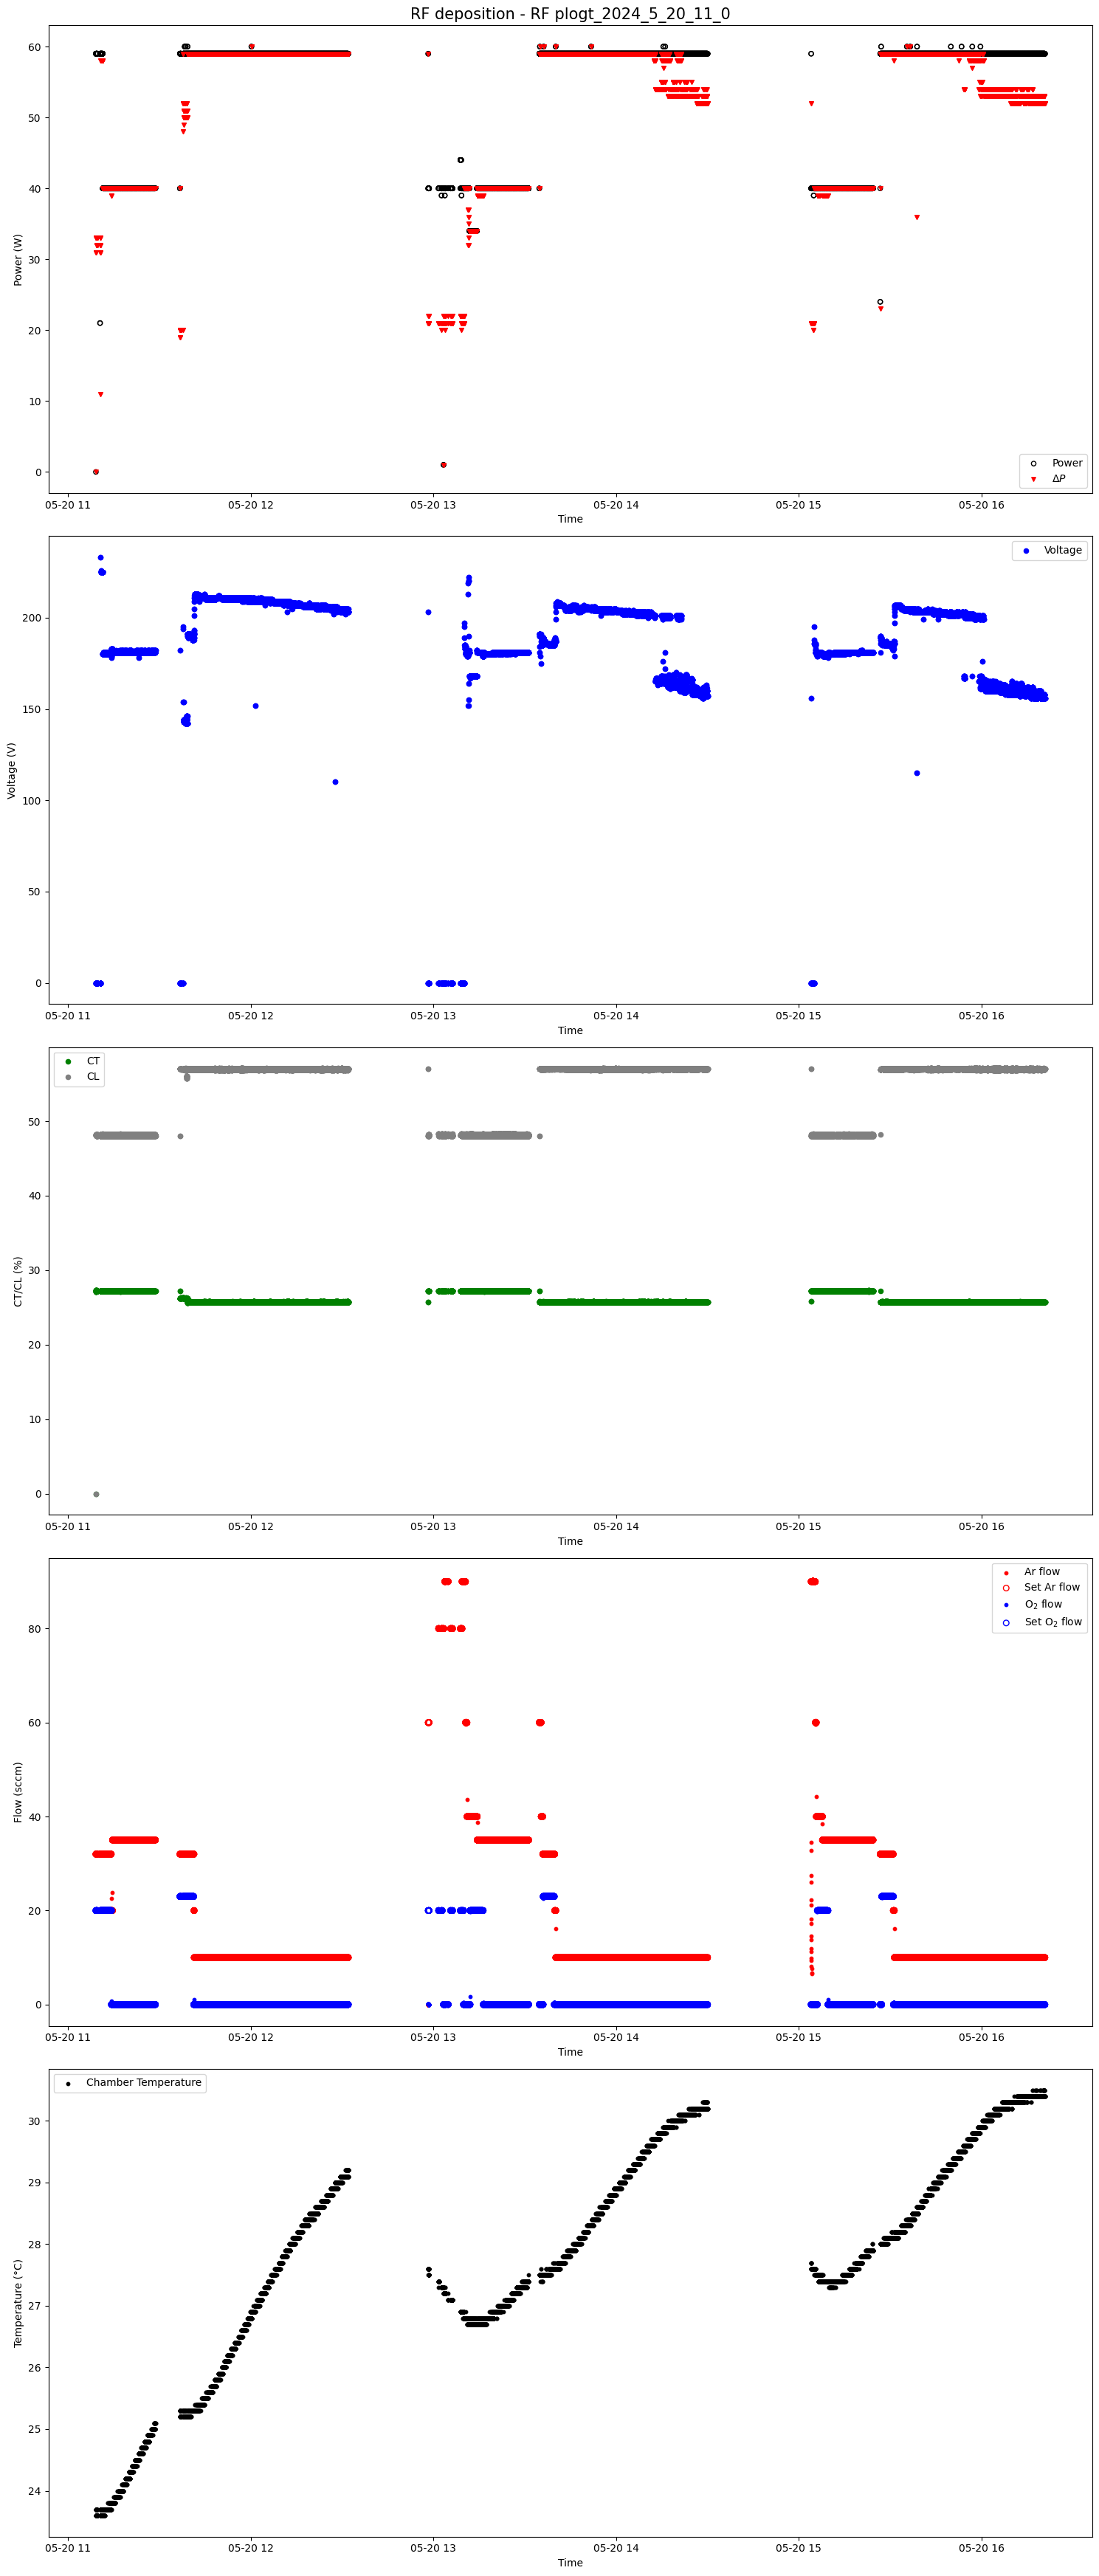

The file plogt_2025_1_30_11_27.log does not have any information to be plotted


In [4]:
log_files = gl.glob('*.log')
dict_logs = {}
for log_file in log_files:
  if 'processed_' not in log_file:
    try:
      df, df_raw = get_data(log_file)
      dict_logs[log_file] = [df, df_raw]
      if 'RF-Power' in df.columns:
        plot_RF(df, log_file)

      elif 'Cu Rich-Mo - real V' in df.columns or 'CIG - real V' in df.columns or 'Mo - real V' in df.columns:
        plot_DC(df, log_file)

      else:
        print("The file {} does not have any information to be plotted".format(log_file))
    except Exception as e:
      print("The file {} has an error: {}".format(log_file, e))
